# Pre- and Post-Burn Canopy Height Change Detection for the Teakettle Experimental Watershed

The goal of this program is to read in pre- and post-burn digital terrain and surface models, calculate canopy height models, and perform a change detection.  
This program requires Point Data Abstraction Library (PDAL) and Python 3.5 to run.

Nicole Abib nicole.abib@duke.edu    
James Lamping jel436@humboldt.edu   
Labeeb Ahmed Lahmed@chesapeakebay.net   
Stephen Escarzaga smescarzaga@utep.edu 
  
NEON Data Institute 2018

Install PDAL in commmand line  
```conda install -c conda-forge pdal python-pdal```

In [1]:
# Check python version
import sys
sys.version

'3.5.5 |Anaconda custom (64-bit)| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]'

In [2]:
# Import required libraries
import numpy as np
import numpy.ma as ma
import gdal, osr, copy
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Use PDAL to generate filter LAS files, merge LAS files, clip LAS file, generate Digital Terrain Model (DTM), and generate Digital Surface Model (DSM).

The Digital Terrain Model created above has holes where no discrete lidar returns reached the ground. There are many reasons this could happen, such as dense tree canopy or water present on the ground.

GDAL's fillnodata algorithm will interpolate values in nodata areas using the surrounding pixels. For each pixel a four direction conic search is done to find values to interpolate from (using inverse distance weighting). Once all values are interpolated, zero or more smoothing iterations (3x3 average filters on interpolated pixels) are applied to smooth out artifacts.

In [3]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]
    
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    
    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()
    
    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
              
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
    
    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = float(dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']))
            band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

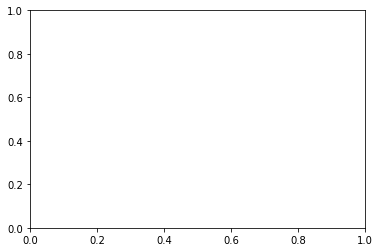

In [4]:
def plot_spatial_array(band_array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(band_array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

In [5]:
# Load in Digital Terrain Model (DTM) created with PDAL for 2017 and 2018
teak_dtm_2017 = '../../BC1_2018_data/output/NEON_TEAK_DTM_2017_final.tif'
teak_dtm_2017_array, teak_dtm_2017_metadata = raster2array(teak_dtm_2017)

teak_dtm_2018 = '../../BC1_2018_data/output/NEON_TEAK_DTM_2018_final.tif'
teak_dtm_2018_array, teak_dtm_2018_metadata = raster2array(teak_dtm_2018)

In [6]:
# Load in Digital Surface Model created with PDAL for 2017 and 2018
teak_dsm_2017 = '../../BC1_2018_data/output/NEON_TEAK_DSM_2017_final.tif'
teak_dsm_2017_array, teak_dsm_2017_metadata = raster2array(teak_dsm_2017)

teak_dsm_2018 = '../../BC1_2018_data/output/NEON_TEAK_DSM_2017_final.tif'
teak_dsm_2018_array, teak_dsm_2018_metadata = raster2array(teak_dsm_2018)

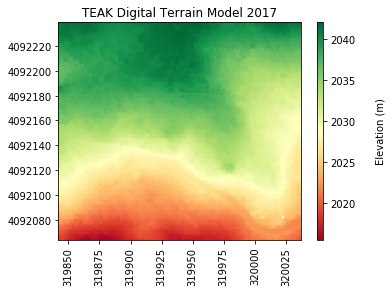

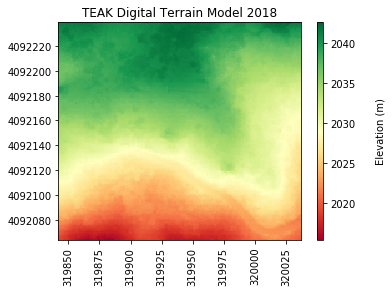

In [7]:
# Plot Digital Terrain Model (DTM) for 2017 and 2018
plt.figure(1)

plot_spatial_array(teak_dtm_2017_array,
                   teak_dtm_2017_metadata['extent'], 
                   colorlimit = [np.nanmin(teak_dtm_2017_array),np.nanmax(teak_dtm_2017_array)],
                   title='TEAK Digital Terrain Model 2017',
                   cmap_title='Elevation (m)',
                   colormap='RdYlGn')

plt.figure(2)

plot_spatial_array(teak_dtm_2018_array,
                   teak_dtm_2018_metadata['extent'], 
                   colorlimit = [np.nanmin(teak_dtm_2018_array),np.nanmax(teak_dtm_2018_array)],
                   title='TEAK Digital Terrain Model 2018',
                   cmap_title='Elevation (m)',
                   colormap='RdYlGn')

plt.savefig('../../BC1_2018_data/output/NEON_TEAK_DTM_2017.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)
plt.savefig('../../BC1_2018_data/output/NEON_TEAK_DTM_2018.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

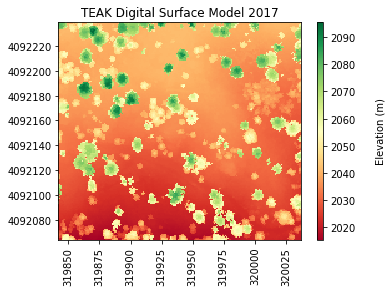

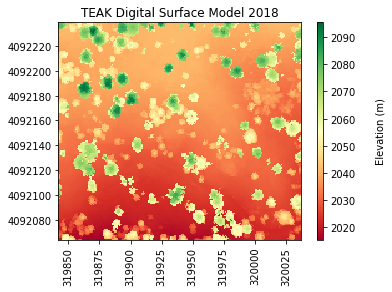

In [8]:
# Plot Digital Surface Model (DSM) for 2017 and 2018
plt.figure(3)

plot_spatial_array(teak_dsm_2017_array,
                   teak_dsm_2017_metadata['extent'], 
                   colorlimit = [np.nanmin(teak_dsm_2017_array),np.nanmax(teak_dsm_2017_array)],
                   title='TEAK Digital Surface Model 2017',
                   cmap_title='Elevation (m)',
                   colormap='RdYlGn')

plt.figure(4)

plot_spatial_array(teak_dsm_2018_array,
                   teak_dsm_2018_metadata['extent'], 
                   colorlimit = [np.nanmin(teak_dsm_2018_array),np.nanmax(teak_dsm_2018_array)],
                   title='TEAK Digital Surface Model 2018',
                   cmap_title='Elevation (m)',
                   colormap='RdYlGn')

plt.savefig('../../BC1_2018_data/output/NEON_TEAK_DSM_2017.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)
plt.savefig('../../BC1_2018_data/output/NEON_TEAK_DSM_2018.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

#### Canopy Height Model is created by subtracting the Digital Terrain Model from the Digital Surface Model.

In [9]:
# Create Canopy Height Model (CHM) for 2017 and 2018
teak_chm_2017_array = np.subtract(teak_dsm_2017_array,teak_dtm_2017_array)
teak_chm_2018_array = np.subtract(teak_dsm_2018_array,teak_dtm_2018_array)

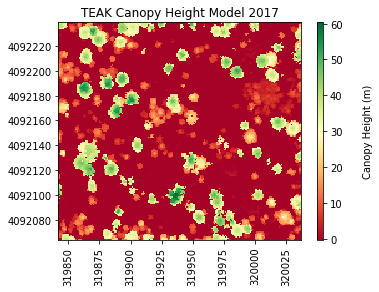

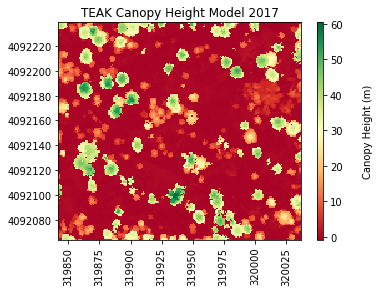

In [10]:
# Plot CHM for 2017 and 2018
plt.figure(5)

plot_spatial_array(teak_chm_2017_array,
                   teak_dsm_2017_metadata['extent'], 
                   colorlimit = [np.nanmin(teak_chm_2017_array),np.nanmax(teak_chm_2017_array)],
                   title='TEAK Canopy Height Model 2017',
                   cmap_title='Canopy Height (m)',
                   colormap='RdYlGn')

plt.figure(6)

plot_spatial_array(teak_chm_2018_array,
                   teak_dsm_2018_metadata['extent'], 
                   colorlimit = [np.nanmin(teak_chm_2018_array),np.nanmax(teak_chm_2018_array)],
                   title='TEAK Canopy Height Model 2017',
                   cmap_title='Canopy Height (m)',
                   colormap='RdYlGn')

plt.savefig('../../BC1_2018_data/output/NEON_TEAK_CHM_2017.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)
plt.savefig('../../BC1_2018_data/output/NEON_TEAK_CHM_2018.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

## Calculate the difference in canopy height before and after a controlled burn by differencing the two Canopy Height Models.

In [11]:
teak_chm_diff = np.subtract(teak_chm_2017_array,teak_chm_2018_array)

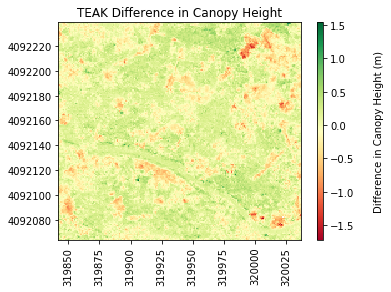

In [12]:
# Plot Difference in canopy height between 2017 and 2018
plt.figure(5)

plot_spatial_array(teak_chm_diff,
                   teak_dsm_2017_metadata['extent'], 
                   colorlimit = [np.nanmin(teak_chm_diff),np.nanmax(teak_chm_diff)],
                   title='TEAK Difference in Canopy Height',
                   cmap_title='Difference in Canopy Height (m)',
                   colormap='RdYlGn')

plt.savefig('../../BC1_2018_data/output/NEON_TEAK_CHM_diff.png',
            dpi=300,
            orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

Text(0,0.5,'Relative Frequency')

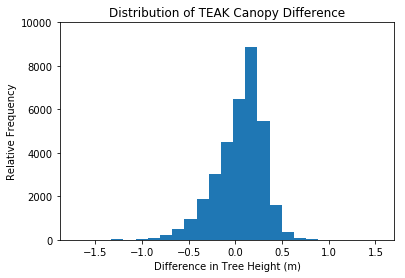

In [13]:
# Plot a histogram of the canopy height model with 100 bins
plt.hist(teak_chm_diff[~np.isnan(teak_chm_diff)],25);
ax = plt.gca()
ax.set_ylim([0,10000])
plt.title('Distribution of TEAK Canopy Difference')
plt.xlabel('Difference in Tree Height (m)')
plt.ylabel('Relative Frequency')

In [14]:
print('Minimum difference in Canopy Height:', np.nanmin(teak_chm_diff))
print('Minimum difference in Canopy Height:', np.nanmax(teak_chm_diff))
print('Minimum difference in Canopy Height:', np.nanstd(teak_chm_diff))

Minimum difference in Canopy Height: -1.7197265625
Minimum difference in Canopy Height: 1.539306640625
Minimum difference in Canopy Height: 0.25549139987752306


### Convert NumPy arrays into GeoTiffs for use in other geospatial software using array2raster function

In [15]:
# Define array2raster to take array data and output a usable geoTIFF
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


In [16]:
# run raster2array on chm
array2raster('../../BC1_2018_data/output/NEON_TEAK_CHM_2017.tif',
             (teak_dtm_2017_metadata['extent'][0],
              teak_dtm_2017_metadata['extent'][3]),1,-1,teak_chm_2017_array,32611)
array2raster('../../BC1_2018_data/output/NEON_TEAK_CHM_2018.tif',
             (teak_dtm_2018_metadata['extent'][0],
              teak_dtm_2018_metadata['extent'][3]),1,-1,teak_chm_2018_array,32611)
array2raster('../../BC1_2018_data/output/NEON_TEAK_CHM_diff.tif',
             (teak_dtm_2018_metadata['extent'][0],
              teak_dtm_2018_metadata['extent'][3]),1,-1,teak_chm_diff,32611)